# DBSCAN v2 with PCA-reduced features on full cohort

In [1]:
import sys
sys.path.append("..")

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.cluster import calculate_k_distances, dbscan_kdist_analysis, \
    assign_dbscan_multidensity, dbscan_kdist_analysis_zoom

## Read in scaled features

In [2]:
df = pd.read_csv("../data/cohort_features_pca_v2_full_cohort.csv", index_col="ID")
df.head(5)

,PC1,PC2
ID,,
0,-9.032719,11.830255
1,-8.036862,-0.142470
2,-7.746563,-0.244233
3,-9.037547,-0.233491
4,-8.751107,-3.319406


## Parameter exploration

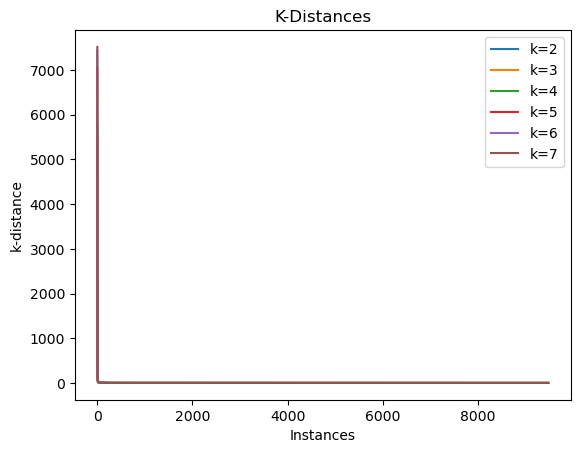

In [3]:
"""
Use k-distances to determine min_pts and eps
k = min_pts - 1
"""
k_list = [2, 3, 4, 5, 6, 7]
dbscan_kdist_analysis(args=(k_list, df))

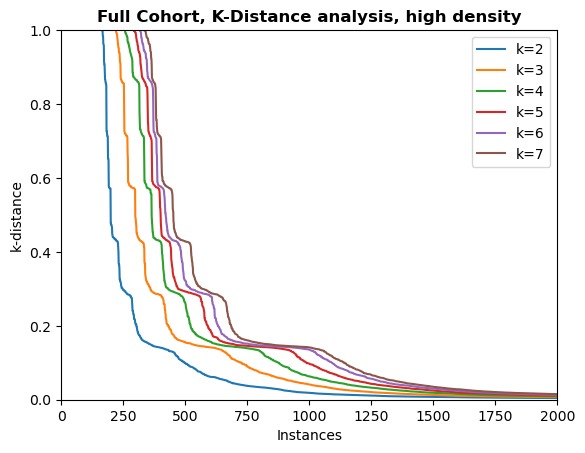

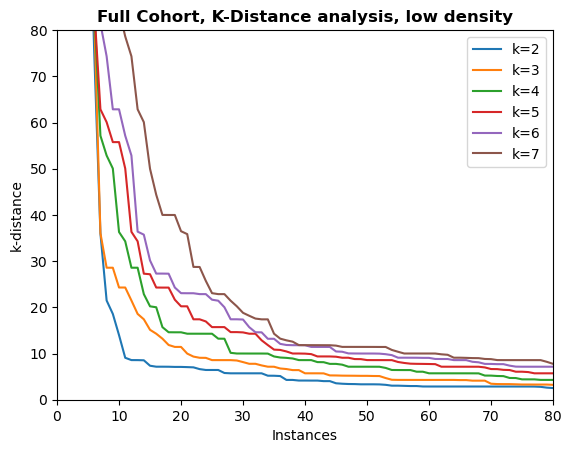

In [17]:
"""
Use k-distances to determine min_pts and eps
k = min_pts - 1
"""
k_list = [2, 3, 4, 5, 6, 7]
dbscan_kdist_analysis_zoom(
    args=(
        k_list, df, 2000, 1,
        f"Full Cohort, K-Distance analysis, high density"
    )
)
dbscan_kdist_analysis_zoom(
    args=(
        k_list, df, 80, 80,
        f"Full Cohort, K-Distance analysis, low density"
    )
)

## Assign the clusters

In [5]:
# eps_list = [0.3, 1.8, 8, 18, 32, 58]
eps_list = [0.15]
k = 4
min_pts = k + 1

assigned_clusters = assign_dbscan_multidensity(args=(eps_list, min_pts, df.copy()))
assigned_clusters.to_csv(f"../data/cohort_clusters_dbscan_v2_pca_full_cohort.csv")
assigned_clusters

DBSCAN run:0 eps:0.15 n:9480


ID
0       1018
1       1000
2       1000
3       1000
4       1001
        ... 
9475    1000
9476    1000
9477    1000
9478    1000
9479    1000
Name: cluster, Length: 9480, dtype: int64

In [6]:
assigned_clusters.value_counts()

 1000    6921
 1001    1477
-1        601
 1003      80
 1002      61
 1010      43
 1008      40
 1004      33
 1007      30
 1005      29
 1015      20
 1017      20
 1016      16
 1013      14
 1009      12
 1014      10
 1022       9
 1020       9
 1023       9
 1006       7
 1011       7
 1012       7
 1018       6
 1019       5
 1021       5
 1024       5
 1025       4
Name: cluster, dtype: int64

## Generate the COS

In [7]:
# Get the cluster label for COS
cos_label = assigned_clusters.value_counts().index[0]
cos_label

1000

In [8]:
# Extract the largest cluster
df_cluster = pd.merge(left=df, right=assigned_clusters, on="ID")
cos = df_cluster[df_cluster["cluster"] == cos_label].drop(columns=["cluster"])
cos.to_csv("../data/cos_pca_dbscan_v2_full_cohort.csv")
cos

,PC1,PC2
ID,,
1,-8.036862,-0.142470
2,-7.746563,-0.244233
3,-9.037547,-0.233491
5,-9.175683,-0.341918
6,-6.609475,-0.219320
...,...,...
9475,-7.750627,-0.268780
9476,-8.894564,-0.180325
9477,-9.036627,-0.244871


In [9]:
# Get the second largest cluster
cos_label_2 = assigned_clusters.value_counts().index[1]
cos_2 = df_cluster[df_cluster["cluster"] == cos_label_2].drop(columns=["cluster"])
cos_2.to_csv("../data/cos_2_pca_dbscan_v2_full_cohort.csv")
cos_2

,PC1,PC2
ID,,
4,-8.751107,-3.319406
7,-7.023249,-3.296972
12,-6.892726,-3.244583
18,-8.173042,-3.304250
22,-5.686301,-3.340011
...,...,...
9447,-7.037272,-3.217447
9452,-8.746003,-3.297511
9466,-6.750695,-3.255187


## Visualise the clusters

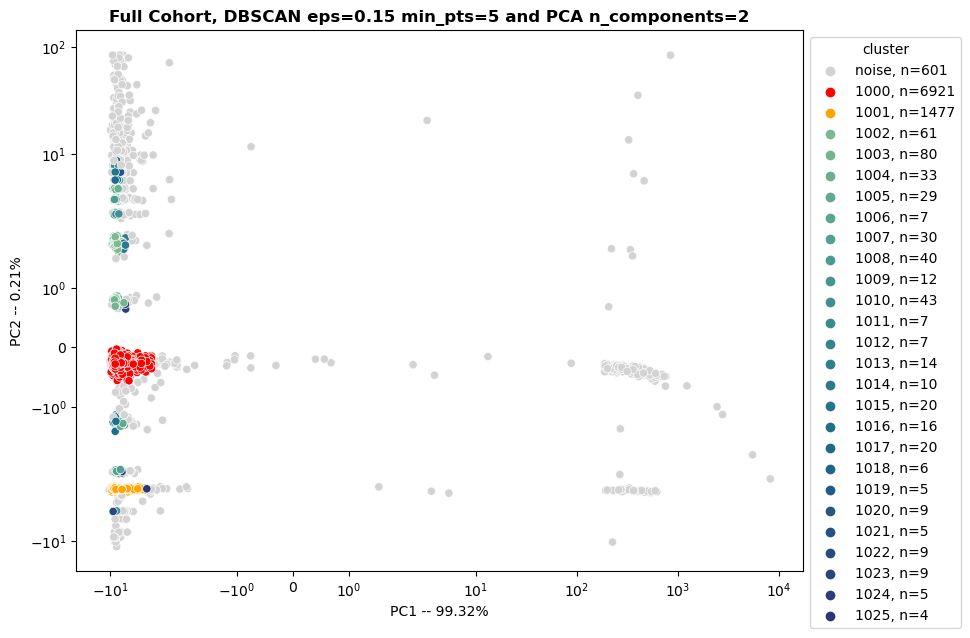

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

pal = sns.color_palette("crest", 27)
pal[0] = "lightgray"
pal[1] = "red"
pal[2] = "orange"
sns.scatterplot(df_cluster, x="PC1", y="PC2", hue="cluster", ax=ax, palette=pal)

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.set_xlabel(f"PC1 -- 99.32%")
ax.set_ylabel(f"PC2 -- 0.21%")

# Set the hue legend texts
hue_lab = [f"{(c, 'noise')[c == -1]}, n={n}" for c, n in
           assigned_clusters.value_counts().sort_index().reset_index().values]
leg = ax.get_legend()
for text, desc in zip(leg.get_texts(), hue_lab):
    text.set_text(desc)
leg.set(bbox_to_anchor=(1, 1))

fig.suptitle("Full Cohort, DBSCAN eps=0.15 min_pts=5 and PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()

In [11]:
cos_los = pd.merge(
    left=cos,
    right=pd.read_csv("../data/cohort_labels_v2_full_cohort.csv", index_col="ID"),
    on="ID"
)
len(cos_los)

6921

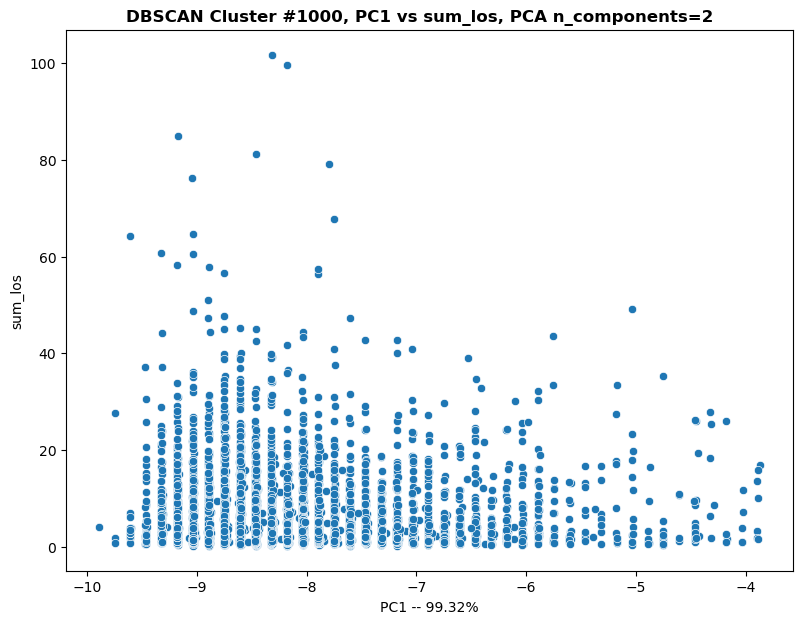

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

sns.scatterplot(cos_los, x="PC1", y="sum_los", ax=ax)

# ax.set_xscale("symlog")
ax.set_xlabel(f"PC1 -- 99.32%")

fig.suptitle("DBSCAN Cluster #1000, PC1 vs sum_los, PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()

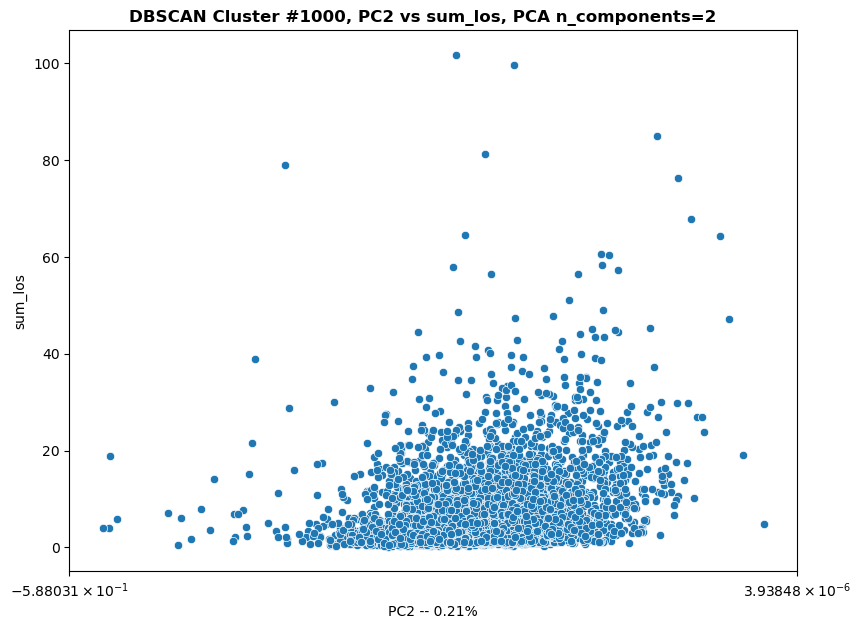

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

sns.scatterplot(cos_los, x="PC2", y="sum_los", ax=ax)

ax.set_xscale("symlog")
ax.set_xlabel(f"PC2 -- 0.21%")

fig.suptitle("DBSCAN Cluster #1000, PC2 vs sum_los, PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()